In [3]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# we have very little data - of only 1300 people (900 in training set). 

### Questions:
1. Cabin meanings, correlations

Miss/Mrs

In [5]:
# The percent of people who survived
print("Survival Percent: ", np.mean(train_df["Survived"]))
noNan_tr = train_df.dropna()
train_df.describe()

print(noNan_tr.describe())

0.3838383838383838
       PassengerId    Survived      Pclass         Age       SibSp  \
count   183.000000  183.000000  183.000000  183.000000  183.000000   
mean    455.366120    0.672131    1.191257   35.674426    0.464481   
std     247.052476    0.470725    0.515187   15.643866    0.644159   
min       2.000000    0.000000    1.000000    0.920000    0.000000   
25%     263.500000    0.000000    1.000000   24.000000    0.000000   
50%     457.000000    1.000000    1.000000   36.000000    0.000000   
75%     676.000000    1.000000    1.000000   47.500000    1.000000   
max     890.000000    1.000000    3.000000   80.000000    3.000000   

            Parch        Fare  
count  183.000000  183.000000  
mean     0.475410   78.682469  
std      0.754617   76.347843  
min      0.000000    0.000000  
25%      0.000000   29.700000  
50%      0.000000   57.000000  
75%      1.000000   90.000000  
max      4.000000  512.329200  


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
numericals = ["Age", "SibSp", "Parch", "Fare"]

def unique_counts(df, column_name, id_field, is_df=True):
  unique_vals = None
  if is_df:
    unique_vals = df[column_name].unique()
  
  counter = dict()
  for val in unique_vals:
    counter[val] = df[df[column_name] == val].count()[id_field]
  return counter

embarked_counts = unique_counts(train_df, "Embarked", "PassengerId")
pclass_counts = unique_counts(train_df, "Pclass", "PassengerId")
train_df["cabin_letters"] = train_df["Cabin"].apply(lambda c_str: 'E' if c_str is np.nan else c_str[0])

print("Embarked: ", embarked_counts)
print("Class: ", pclass_counts)
print("Cabin: ", Counter(train_df["cabin_letters"]))

Embarked:  {'S': 644, 'C': 168, 'Q': 77, nan: 0}
Class:  {3: 491, 1: 216, 2: 184}
Cabin:  Counter({'E': 719, 'C': 59, 'B': 47, 'D': 33, 'A': 15, 'F': 13, 'G': 4, 'T': 1})


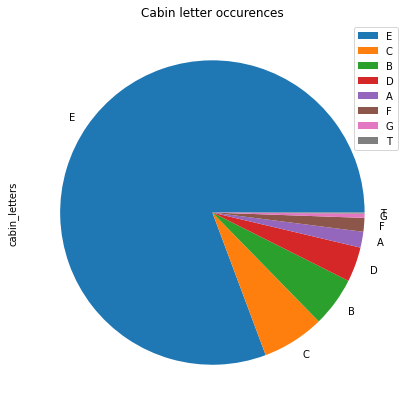

In [21]:
# We can see that most of the cabins are nulls. If the variables arent missing
# randomly, we could get good information about the non-null cabins.
fig, ax = plt.subplots()
train_df["cabin_letters"].value_counts().plot(kind='pie', title="Cabin letter occurences", 
                                              legend=True, rot=1, figsize=(7, 7)).legend(loc="upper right")

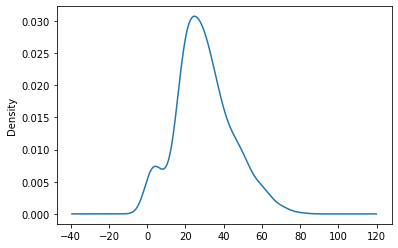

In [9]:
train_df["Age"].plot(kind="density") # It seems like the variance is relatively low - imputing the median seems like a good choice for now.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

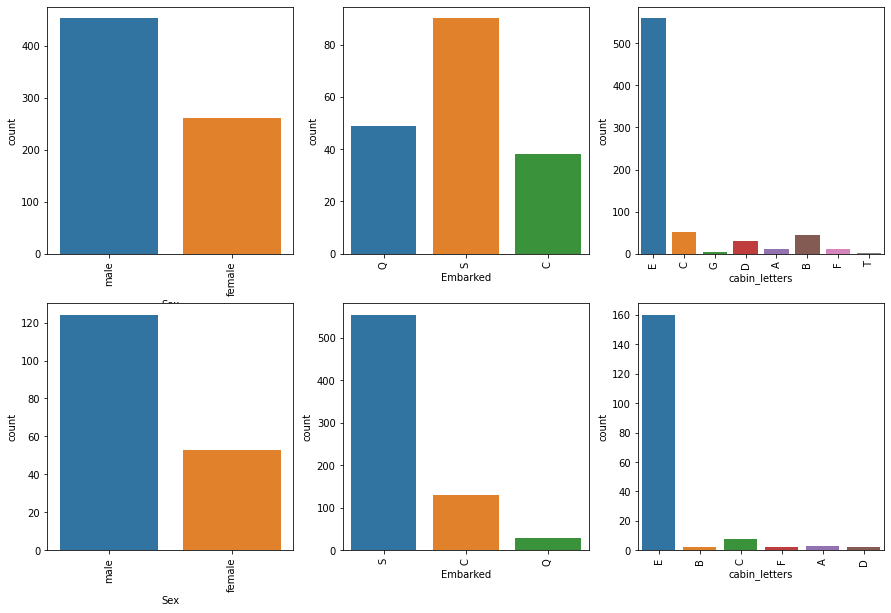

In [10]:
# Trying to graph relationships between Age and other values.
age_nans = np.isnan(train_df["Age"])

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
categorical = ["Sex", "Embarked", "cabin_letters"]*2

counter = 0
for variable, subplot in zip(categorical, ax.flatten()):
    nan_usage = age_nans
    if counter % 2 == 0:
      nan_usage = ~age_nans
    counter += 1
    sns.countplot(train_df[nan_usage][variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)


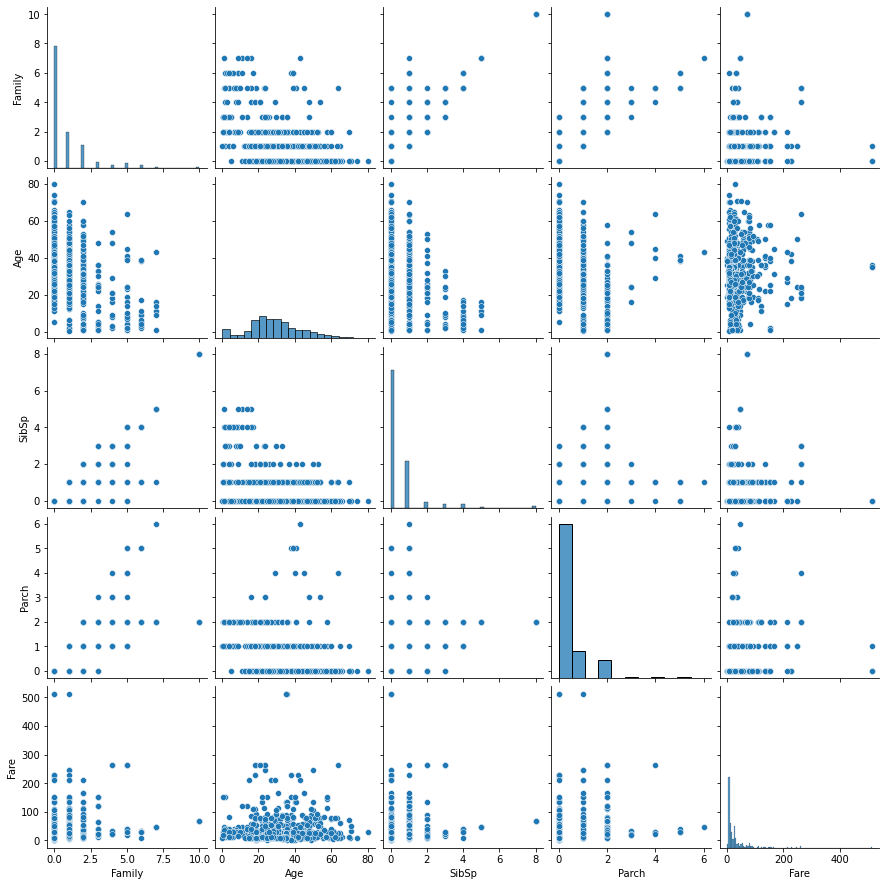

In [11]:
d1 = train_df.copy()
d1["Family"] = d1["SibSp"] + d1["Parch"]
sns.pairplot(d1[["Family"] + numericals])

In [12]:
def null_rows(df):
  return df[df.isnull().values == True] # rows with nan 

def preproc_general(df):
  data_df = df.copy()

  # creating new feature - 'cabin letter'
  data_df["cabin_letters"] = data_df["Cabin"].apply(lambda c_str: 'E' if c_str is np.nan else c_str[0])
  
  # dropping variables that arent useful (they are either unique or we extracted their value)
  data_df.drop(["Name", "Ticket", "Cabin"], axis=1)

  # imputing age, and Embarked
  data_df = data_df.fillna({"Embarked": "Unknown", "Age": data_df["Age"].median(), "Fare": data_df["Fare"].median()})
  
  # creating the family variable
  data_df["family"] = data_df["SibSp"] + data_df["Parch"]

  return data_df

def preprocess_log(df):
  data_df = preproc_general(df)

  # making dummy vars
  dummies = pd.get_dummies(["Sex", "Embarked", "cabin_letters"])
  data_df = pd.concat([data_df, dummies], axis=1)

  data_df = data_df.drop(columns=["Cabin", "Name", "PassengerId", "Ticket", "Sex", "Embarked", "cabin_letters"])


  
  if "Survived" in data_df.columns:
    return data_df.drop(columns="Survived"), data_df["Survived"]
  return data_df

def preprocess_rand_forest(df):
  return preprocess_log(df)

In [13]:
# Trying Logistic Regression on the data so far:
X, y = preprocess_log(train_df)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.17)
LogReg = LogisticRegressionCV(cv=10, solver="lbfgs", max_iter=300)
LogReg.fit(X_train, y_train)
cv = cross_val_score(LogReg, X, y, cv=5)
print("CV Score Logistic Regression: ", cv)
print("CV mean: ", np.mean(cv))

CV Score Logistic Regression:  [0.62569832 0.69101124 0.7247191  0.71910112 0.70224719]
CV mean:  0.692555395141548


In [14]:
from sklearn import preprocessing
# Lets try to predict the residuals with a random forest:
tree_res_data = X_train.copy()
# predict_proba gives 2 col df - col1 is P(y=0|xi), cal2 is P(y=1|xi). we take P(y=1|xi) (dont think it matters though)
tree_res_data["residual"] = np.abs(y - LogReg.predict_proba(X).T[1])

trained_tree, params, score = preproced_RF_grid_train(tree_res_data, y)
cv_res = cross_val_score(trained_tree, tree_res_data, y, cv=5)
print("Training Score: ", score)
print(cv_res)
print(params)

NameError: ignored

In [ ]:
predicted = trained_tree.fit(predict(test_df)
predicted

In [ ]:
# training a tree on preprocessed data.
def preproced_RF_grid_train(X, y):
  # grid search (note: I played with the grid search ahead of time - this is a demonstration)
  models = dict()
  criteria = ["gini", "entropy"]
  max_depths = [3, 7, 8, None]
  min_splits = [2, 5, 10]

  for crit in criteria:
    for depth in max_depths:
      for min_split in min_splits:
        tree = RandomForestClassifier(criterion=crit, max_depth=depth, min_samples_split=min_split)
        models[(depth, min_split, crit)] = np.mean(cross_val_score(tree, X, y, cv=2))

  best_params, score = max(models.items(), key=lambda x: x[1])
  best_tree = RandomForestClassifier(criterion=best_params[2], max_depth=best_params[0], 
                                   min_samples_split=best_params[1])
  return best_tree, best_params, score

In [ ]:
from heapq import heapify, heappush, heappop

# Trying Random Forest
X, y = preprocess_rand_forest(train_df)
forest_mod = RandomForestClassifier()

# grid search (note: I played with the grid search ahead of time - this is a demonstration)
models = dict()
criteria = ["gini", "entropy"]
max_depths = [3, 7, 8, None]
min_splits = [2, 5, 10]

for crit in criteria:
  for depth in max_depths:
    for min_split in min_splits:
      tree = RandomForestClassifier(criterion=crit, max_depth=depth, min_samples_split=min_split)
      models[(depth, min_split, crit)] = np.mean(cross_val_score(tree, X, y, cv=2))


best_params, score = max(models.items(), key=lambda x: x[1])
print("training score: ", score)
best_tree = RandomForestClassifier(criterion=best_params[2], max_depth=best_params[0], 
                                   min_samples_split=best_params[1])
cv =  cross_val_score(best_tree, X, y, cv=5)
print("best params: ", best_params)
print("CV Score Tree: ", cv)
print("mean: ", np.mean(cv))

In [ ]:
null_rows(X_test)

In [ ]:
X[X.isnull().values == True] # rows with nan 